# Sleep EEG preprocessing, spectral analyses and events detection

## Introductory notes:
This notebook presents minimal functionality needed to go through the cleaning, ICA and spectral and event analyses stages.
* For the cleaning part the functionality consists of resampling, filtering, bad channels and bad data spans annotation and bad channels interpolation.
* For the ICA part it is fitting and selecting components you want to exclude.
* For the spectral analyses part it is spectrogram+hypnogram, PSD per sleep stage and topomap per sleep stage per frequency band.
* For the events detection it is spindles, slow waves and rapid eye movements detection and analysis.

For the extended functionality check out corresponding notebooks.

### Import module

In [1]:
%matplotlib widget
from sleepeeg.pipeline import (
    CleaningPipe, ICAPipe, SpectralPipe, 
    SpindlesPipe, SlowWavesPipe, RapidEyeMovementsPipe
    )

## Cleaning

Initialize `CleaningPipe` object by providing it with path to eeg file and output directory in which you want the data to be saved.

In [2]:
pipe = CleaningPipe(
    path_to_eeg=r"C:\Users\Gennadiy\Documents\data\HZ4\HZ4_SLEEP_20210629_132715.mff",
    output_dir=r"C:\Users\Gennadiy\Documents\data\HZ4\processing",
)

Reading EGI MFF Header from C:\Users\Gennadiy\Documents\data\HZ4\HZ4_SLEEP_20210629_132715.mff...
    Reading events ...
    Assembling measurement info ...


### Resampling
This can take more than an hour depending on eeg signal size and specs of the computer you're running the analysis on.

In [4]:
pipe.resample(
    sfreq=250,  # Desired new sampling frequency
)

### Filtering
Bandpass and notch filters

In [5]:
pipe.filter(l_freq=0.3, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Filter length: 2751 samples (11.004 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed:    9.6s finished


In [6]:
pipe.notch(freqs="50s")

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed:    8.9s finished


### Select bad channels and epochs

Select bad channels in the opened browser.

In [ ]:
pipe.plot()

In [7]:
pipe.read_bad_channels()

In [8]:
pipe.interpolate_bads(reset_bads=True)

Interpolating bad channels
    Automatic origin fit: head of radius 96.5 mm
Computing interpolation matrix from 220 sensor positions
Interpolating 37 sensors


Select bad epochs

Click "a" -> "Add description" -> Enter BAD_EPOCH -> Annotate bad data spans

In [ ]:
pipe.plot(butterfly=True)

In [9]:
pipe.read_annotations()

## ICA

Pass the preceding (cleaning) pipe to the ICAPipe.

In [15]:
ica_pipe = ICAPipe(prec_pipe=pipe, n_components=30)

Fit the ICA on the 1 Hz high-pass fitered data.

In [17]:
ica_pipe.fit()

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed:   10.5s finished


Fitting ICA to data using 257 channels (please be patient, this may take a while)
Omitting 166504 of 2229773 (7.47%) samples, retaining 2063269 (92.53%) samples.
Selecting by number: 30 components
Fitting ICA took 131.9s.


Visually inspect ICA components.

In [18]:
ica_pipe.plot_sources()

Creating RawArray with float64 data, n_channels=31, n_times=2229773
    Range : 0 ... 2229772 =      0.000 ...  8919.088 secs
Ready.
Using qt as 2D backend.


Pass to the `exclude` argument indices of components you want to remove from the raw signal.

In [19]:
ica_pipe.apply(exclude=[25, 26])

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 257 PCA components


## Spectral

Pass the preceding (cleaning or ICA) pipe to the SpectralPipe. Also provide pass to the hypnogram and don't forget to pass its frequency to the corresponding parameter.

In [3]:
spectral_pipe = SpectralPipe(
    prec_pipe=pipe,
    path_to_hypno=r"C:\Users\Gennadiy\Documents\data\HZ4\staging.txt",
    hypno_freq=1,
)

Hypnogram is LONGER than data by 0.91 seconds. Cropping hypnogram to match data.size.


If you don't have a hypnogram, you can use the method `predict_hypno`, which will use [YASA's algorithm](https://raphaelvallat.com/yasa/build/html/generated/yasa.SleepStaging.html#yasa.SleepStaging). 

Make sure that the electrodes you provide are clean.

In [ ]:
# spectral_pipe.predict_hypno(
#         eeg_name = "E183",
#         eog_name = "E252",
#         emg_name = "E247",
#         ref_name = "E26",
#         save=False
# )

Pass an electrode name to calculate spectrogram for (e.g., E101)

Setting 166506 of 2229773 (7.47%) samples to NaN, retaining 2063267 (92.53%) samples.


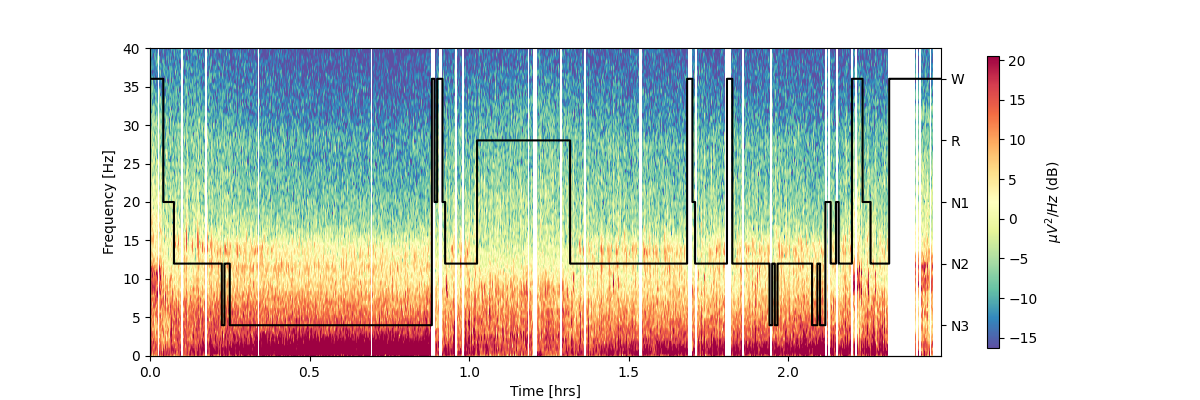

In [12]:
spectral_pipe.plot_hypnospectrogram(picks=["E101"])

In [13]:
spectral_pipe.compute_psds_per_stage(
    sleep_stages={"Wake": 0, "N1": 1, "N2/3": (2, 3), "REM": 4},
    reference="average",
    method="welch",  # welch or multitaper
    # Additional arguments passed to the PSD computing method, i.e., welch or multitaper:
    n_fft=1024,
    n_per_seg=1024,
    n_overlap=512,
    window="hamming",
)

Reading 0 ... 2229772  =      0.000 ...  8919.088 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Setting 166506 of 2229773 (7.47%) samples to NaN, retaining 2063267 (92.53%) samples.
Setting 166506 of 2229773 (7.47%) samples to NaN, retaining 2063267 (92.53%) samples.
Setting 166506 of 2229773 (7.47%) samples to NaN, retaining 2063267 (92.53%) samples.
Setting 166506 of 2229773 (7.47%) samples to NaN, retaining 2063267 (92.53%) samples.


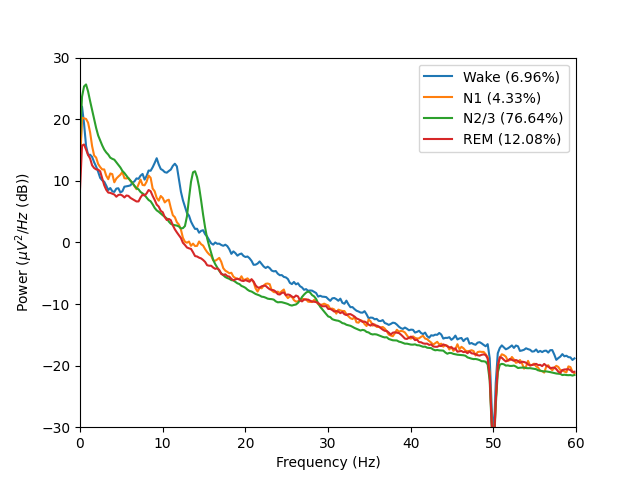

In [14]:
spectral_pipe.plot_psds(picks=["E101"], psd_range=(-30, 30))

Create a collage with rows for sleep stages and columns for bands.

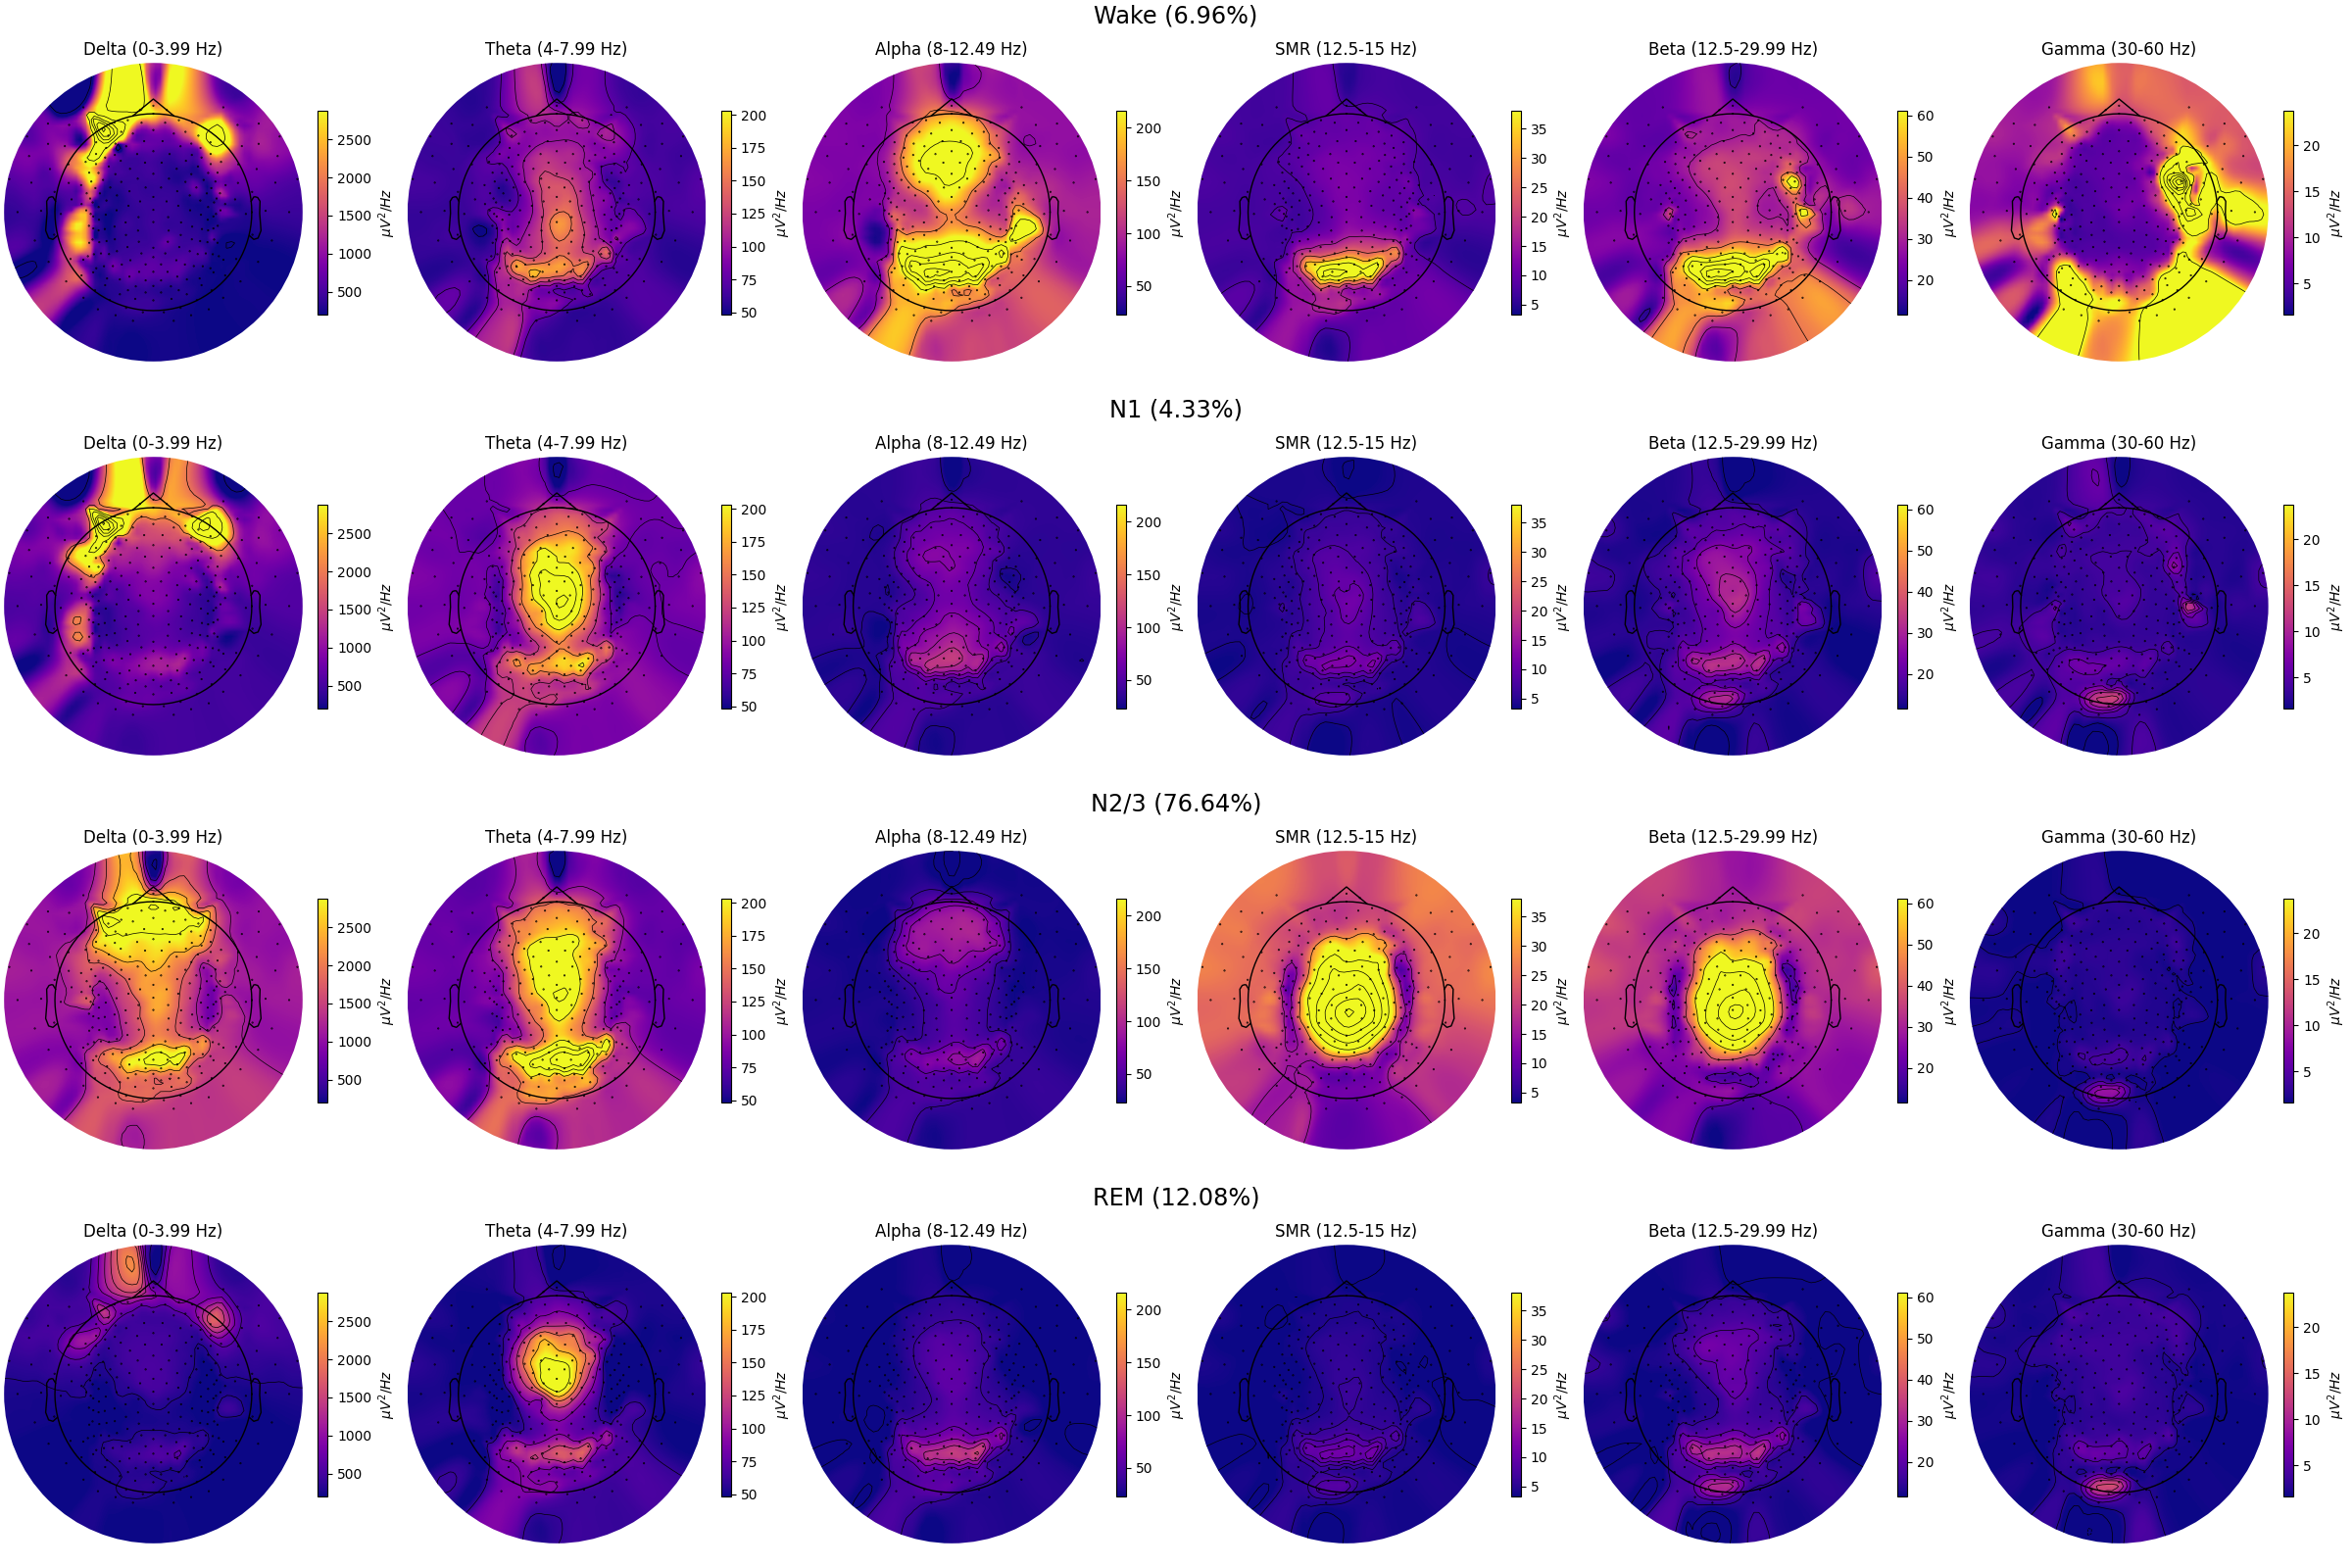

In [15]:
spectral_pipe.plot_topomap_collage()

## Events

Pass the preceding (cleaning or ICA or spectral) pipe to one of the SpindlesPipe, SlowWavesPipe or RapidEyeMovementsPipe. If the preceding is cleaning or ICA - provide path to the hypnogram and don't forget to pass its frequency to the corresponding parameter.

05-Jun-23 15:06:27 | WARNING | Hypnogram is LONGER than data by 0.91 seconds. Cropping hypnogram to match data.size.


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed:   10.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed:   12.5s finished


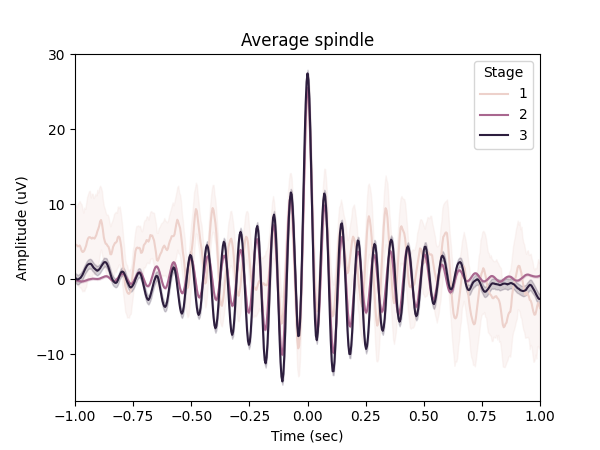

In [31]:
spindles_pipe = SpindlesPipe(prec_pipe=spectral_pipe)

spindles_pipe.detect()
spindles_pipe.plot_average(
    center="Peak",
    hue="Stage",
    time_before=1,
    time_after=1,
)

100%|██████████| 88/88 [00:01<00:00, 70.08it/s]


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


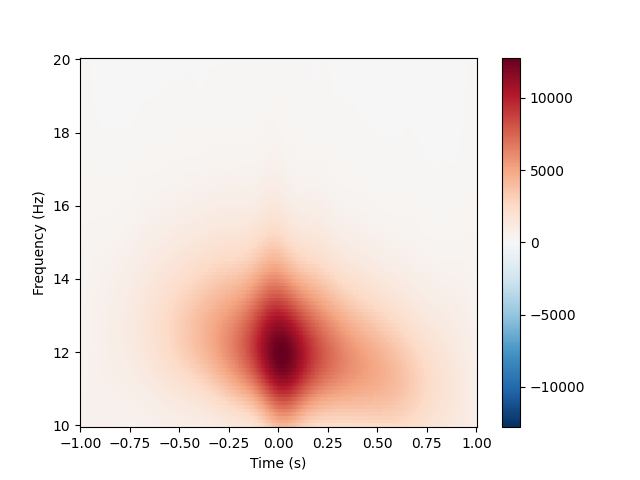

[<Figure size 640x480 with 2 Axes>]

In [32]:
spindles_pipe.apply_tfr(freqs=(10, 20), n_freqs=100, time_before=1, time_after=1)
spindles_pipe.tfrs["N2"].plot(["E101"])

05-Jun-23 15:17:47 | WARNING | Hypnogram is LONGER than data by 0.91 seconds. Cropping hypnogram to match data.size.


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 257 out of 257 | elapsed:   12.0s finished


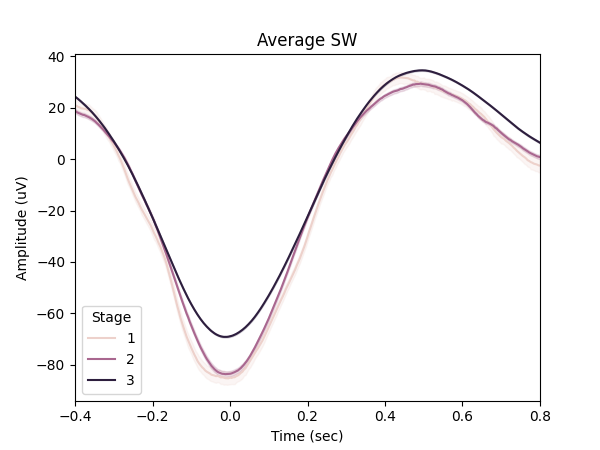

In [33]:
slow_waves_pipe = SlowWavesPipe(prec_pipe=spindles_pipe)

slow_waves_pipe.detect()
slow_waves_pipe.plot_average(
    center="NegPeak",
    hue="Stage",
    time_before=0.4,
    time_after=0.8,
)

100%|██████████| 252/252 [00:13<00:00, 19.09it/s]


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


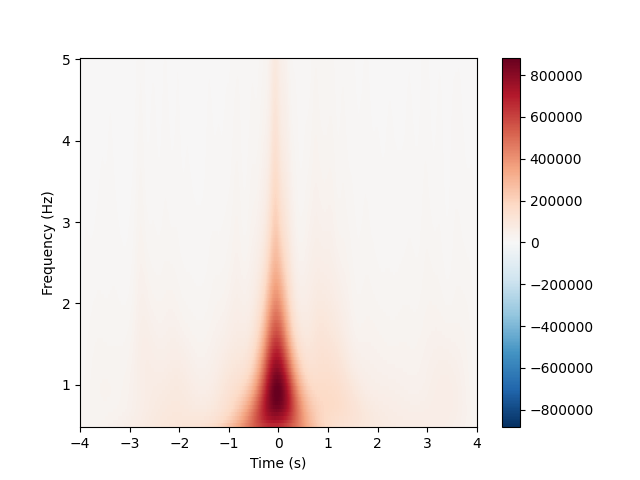

[<Figure size 640x480 with 2 Axes>]

In [35]:
slow_waves_pipe.apply_tfr(
    freqs=(0.5, 5), n_freqs=100, time_before=4, time_after=4, n_cycles=2
)
slow_waves_pipe.tfrs["N2"].plot(["E101"])

05-Jun-23 15:42:41 | WARNING | Hypnogram is LONGER than data by 0.91 seconds. Cropping hypnogram to match data.size.


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Setting 166504 of 2229773 (7.47%) samples to NaN, retaining 2063269 (92.53%) samples.
Setting 166504 of 2229773 (7.47%) samples to NaN, retaining 2063269 (92.53%) samples.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


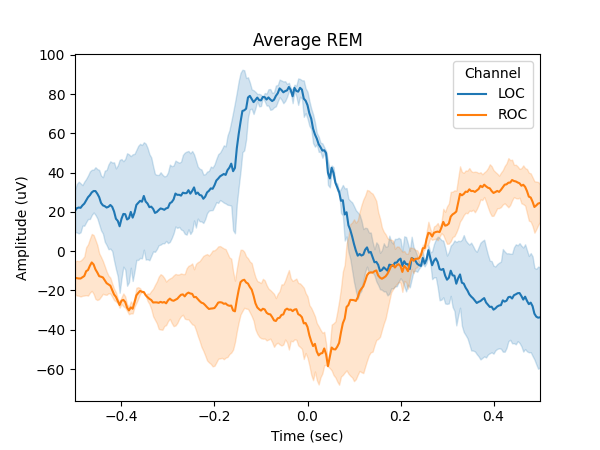

In [36]:
rems_pipe = RapidEyeMovementsPipe(prec_pipe=slow_waves_pipe)

rems_pipe.detect(
    loc_chname="E252",
    roc_chname="E226",
)

rems_pipe.plot_average(
    center="Peak",
    time_before=0.5,
    time_after=0.5,
    filt=(None, None),
    mask=None,
)